# NLP with Disaster Tweets

This project aims to use natural language processing (NLP) to classify whether a given tweet is about a real disaster or not. NLP is a subfield of computer science related to analyzing and generating human language using machine learning. This project will develop and tune two recurrent neural network (RNN) deep learning models to classify tweets: a Long Short-Term Memory (LSTM) model and a Gated Recurrent Unit (GRU) model. Both models will be trained and tuned, and their performance will be evaluated and compared.

The dataset used in this project is from the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) competition on Kaggle. The training dataset contains 7613 tweets that are labeled disaster or not, and contains the following columns:
- `id`: unique identifier
- `keyword`: keyword from the tweet (optional)
- `location`: location the tweet was sent from (optional)
- `text`: text of the tweet
- `target`: whether a tweet is about a real disaster (1) or not (0)

## Setup

We'll begin by importing the necessary libraries and modules and loading the data. We'll also take a glimpse at the first few rows of the training dataset and print out its shape.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Load both datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Print the shape of the training dataset
print('Shape:', train_df.shape)

# Display the first few rows of the training dataset
train_df.head()

Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis

We'll begin the exploratory data analysis by plotting and evaluating the distribution of the target variable to see whether the dataset is balanced or not. We'll also look at the distribution of the number of characters by target and the most common words by target. From there, we'll preprocess the text data by removing stopwords, punctuation, and converting the text to lowercase.

In [3]:
# Target name mapping
target_name_mapping = {
    0: 'no disaster',
    1: 'disaster'
}

# Map labels to integers
train_df['target_name'] = train_df['target'].map(target_name_mapping)

# Append the length of the text to the dataframe for analysis
train_df['text_length'] = train_df['text'].str.len()

# Define stopwords
stop_words = stopwords.words('english') + ['-', '...', '&amp;', '??']

target_name
no disaster    4342
disaster       3271
Name: count, dtype: int64


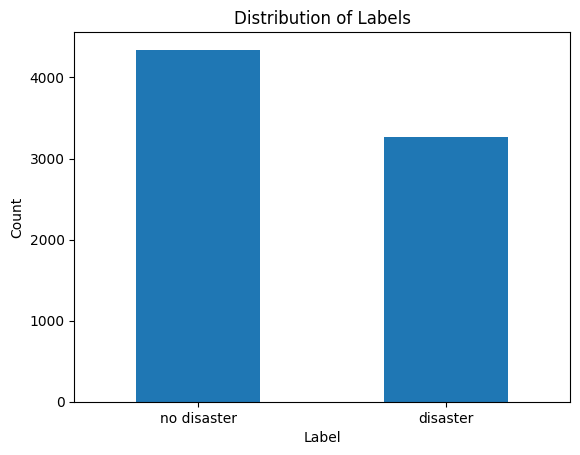

In [ ]:
# Distribution of target labels
label_counts = train_df['target_name'].value_counts()
print(label_counts)

label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

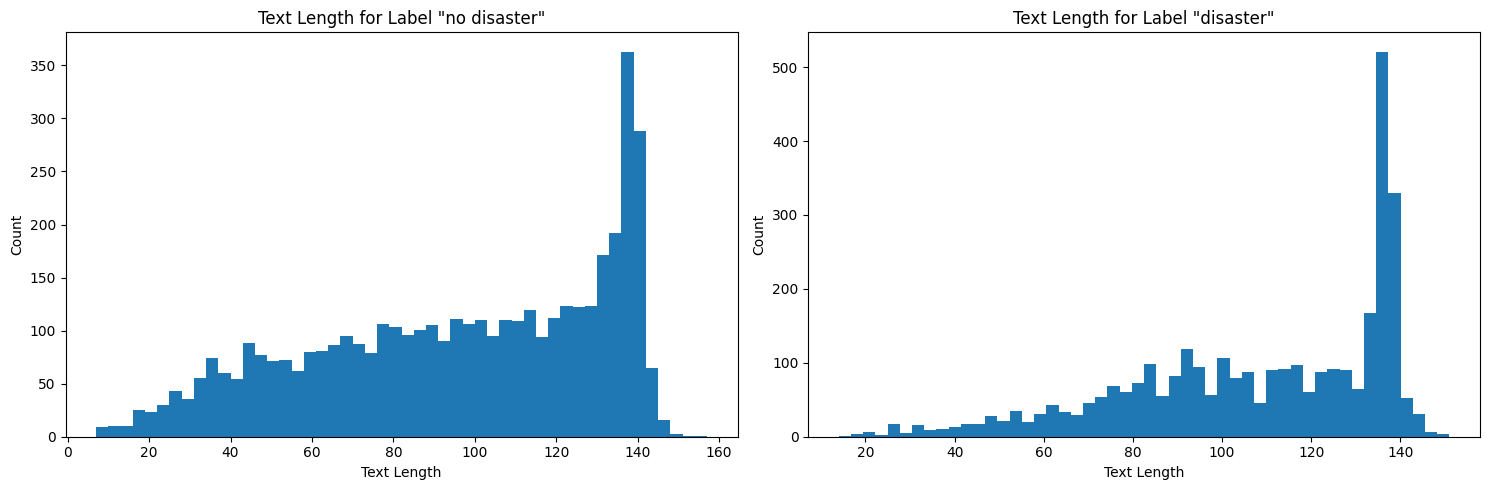

In [ ]:
# Distribution of character counts by label
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, label in target_name_mapping.items():
    axs[i].hist(train_df[train_df['target_name'] == label]['text_length'], bins=50)
    axs[i].set_title(f'Text Length for Label "{label}"')
    axs[i].set_xlabel('Text Length')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

/var/folders/hj/ldmxw7n16190zgh_c6m4mxgm0000gq/T/ipykernel_11568/1247761346.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(words, rotation=45)
/var/folders/hj/ldmxw7n16190zgh_c6m4mxgm0000gq/T/ipykernel_11568/1247761346.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(words, rotation=45)


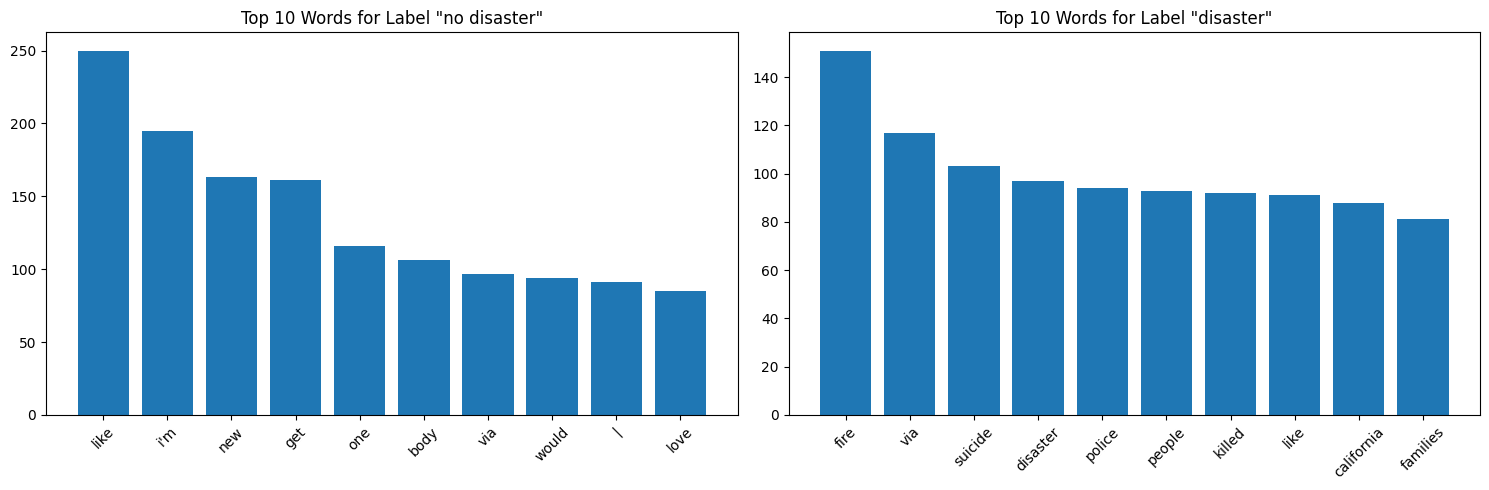

In [ ]:
# Top 10 most frequent words for each label, removing stopwords
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, label in target_name_mapping.items():
    text = ' '.join(train_df[train_df['target_name'] == label]['text'])
    words = [word.lower() for word in text.split()]
    words = [word for word in words if word not in list(stop_words)]
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    words, counts = zip(*most_common_words)
    axs[i].bar(words, counts)
    axs[i].set_title(f'Top 10 Words for Label "{label}"')
    axs[i].set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Preprocess the text data
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    # Remove special characters
    text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in text])
    return text

train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

## Training Models

We'll begin the model training process by tokenizing the text and padding the sequences. Tokenizing converts words into a sequence of numbers which so that the text data can be used by our RNN models. We'll then split the data into training and validation datasets. We'll train and tune an LSTM model and a GRU model, tune their hyperparameters, and evaluate their performance.

Both the LSTM and GRU models are types of RNNs that are designed to handle sequential data, like text. The LSTM model is designed to handle long-term dependencies in the data, while The GRU model is a simplified version of the LSTM model and is designed to be more efficient. It should be interesting to see how they compare in terms of performance and efficiency!

In [8]:
# Tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to sequence of tokens
X_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Print max length of the cleaned text from both datasets
print(f"Max text length: {max([len(text) for text in X_train + X_test])}")

Max text length: 34


Text(0, 0.5, 'Count')

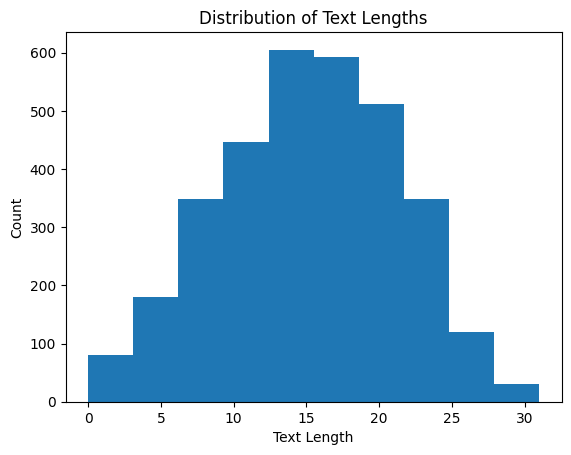

In [ ]:
# Distribution of text lengths to inform padding
text_lengths = [len(text) for text in X_test]
plt.hist(text_lengths, bins=10)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')

After preprocessing and tokenization, we see that the max text length is 34. We will pad the sequences to a length of 50 to ensure that all sequences have the same length and in case any unseen data contains more then than 34 tokens.

In [10]:
# Pad sequences to 50 tokens since the max text length is 34
max_text_length = 50

X_train = pad_sequences(X_train, maxlen=max_text_length)
X_test = pad_sequences(X_test, maxlen=max_text_length)

# Prepare the target labels
y_train = train_df['target'].values

# Train/test split on training dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Store other values to be used in the models
input_dim = len(tokenizer.word_index) + 1

### LSTM Architecture and Training

Our LSTM model will consist of an embedding layer, an LSTM layer, and a dense layer. We'll compile the model using the Adam optimizer and binary cross-entropy loss. We'll train the first model, `lstm_model_1`, for 5 epochs. After evaluating it's performance, we will adjust the hyperparameters and train a second model, `lstm_model_2`. We will adjust the learning rate, the number of units in the LSTM layer, the batch size, and the number of epochs. We will introduce early stopping to prevent overfitting.

In [11]:
# Create and train the first LSTM model
lstm_model_1 = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=max_text_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model_1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

lstm_history_1 = lstm_model_1.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/5


/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6213 - loss: 0.6434 - val_accuracy: 0.7886 - val_loss: 0.4624
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8502 - loss: 0.3702 - val_accuracy: 0.8076 - val_loss: 0.4407
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9245 - loss: 0.2073 - val_accuracy: 0.7827 - val_loss: 0.5006
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9559 - loss: 0.1245 - val_accuracy: 0.7689 - val_loss: 0.5991
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9763 - loss: 0.0748 - val_accuracy: 0.7492 - val_loss: 0.7224


In [12]:
# Create and train the second LSTM model
lstm_model_2 = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=max_text_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model_2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

lstm_history_2 = lstm_model_2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5804 - loss: 0.6831 - val_accuracy: 0.6021 - val_loss: 0.6515
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6346 - loss: 0.6426 - val_accuracy: 0.7006 - val_loss: 0.6037
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7282 - loss: 0.5689 - val_accuracy: 0.7794 - val_loss: 0.5092
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8197 - loss: 0.4346 - val_accuracy: 0.8083 - val_loss: 0.4556
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8717 - loss: 0.3378 - val_accuracy: 0.7971 - val_loss: 0.4537
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8874 - loss: 0.2916 - val_accuracy: 0.8102 - val_loss: 0.4475
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9117 - loss: 0.2424 - val_accuracy: 0.8129 - val_loss: 0.4582
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9249 - loss: 0.2155 - val_acc

Adjusting the learning rate from the default value of 0.001 down to 0.0001 seemed to have the greatest impact on the model's performance. The model is no longer overfitting as much as before. Adjusting the batch size from 64 to 32 also helped improve the model's performance. Adjusting the number of nodes in the LSTM layer seemed to only decrease performance, so it was kept at 100.

### GRU Architecture and Training

Our GRU model will consist of an embedding layer, a GRU layer, and a dense layer. We'll compile the model using the Adam optimizer and binary cross-entropy loss. We'll train the first model, `gru_model_1`, for 5 epochs. After evaluating it's performance, we will adjust the hyperparameters and train a second model, `gru_model_2`. Similar to the LSTM model, we will adjust the learning rate, the number of units in the GRU layer, the batch size, and the number of epochs. We will introduce early stopping to prevent overfitting.

In [13]:
# Create and train the first GRU model
gru_model_1 = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=max_text_length),
    SpatialDropout1D(0.2),
    GRU(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

gru_model_1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

gru_history_1 = gru_model_1.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.6085 - loss: 0.6560 - val_accuracy: 0.7564 - val_loss: 0.5106
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8499 - loss: 0.3680 - val_accuracy: 0.7472 - val_loss: 0.5161
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9143 - loss: 0.2156 - val_accuracy: 0.7722 - val_loss: 0.5457
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9685 - loss: 0.0928 - val_accuracy: 0.7603 - val_loss: 0.7146
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9845 - loss: 0.0454 - val_accuracy: 0.7439 - val_loss: 0.7861


In [14]:
# Create and train the second GRU model
gru_model_2 = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=max_text_length),
    SpatialDropout1D(0.2),
    GRU(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

gru_model_2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

gru_history_2 = gru_model_2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5630 - loss: 0.6873 - val_accuracy: 0.5739 - val_loss: 0.6546
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6185 - loss: 0.6438 - val_accuracy: 0.6592 - val_loss: 0.6139
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6885 - loss: 0.5803 - val_accuracy: 0.7518 - val_loss: 0.5351
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8082 - loss: 0.4496 - val_accuracy: 0.7538 - val_loss: 0.4920
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8569 - loss: 0.3488 - val_accuracy: 0.7905 - val_loss: 0.4630
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8935 - loss: 0.2732 - val_accuracy: 0.7886 - val_loss: 0.4756
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9219 - loss: 0.2173 - val_accuracy: 0.7938 - val_loss: 0.4919


Similar to the LSTM model, decreasing the learning rate of the GRU model to 0.0001 seemed to improve the model's performance the most and ameliorate overfitting. Adjusting the batch size from 64 to 32 may have also helped to improve the performance, but adjusting the number of nodes in the GRU layer did not have much of an impact on the model's performance, so it was kept at 100.

## Results and Analysis

### Accuracy and Loss

The first metrics we will evaluate are the accuracy and loss of the models on the training and validation datasets. We will plot the training and validation accuracy and loss across epochs for the LSTM and GRU models.

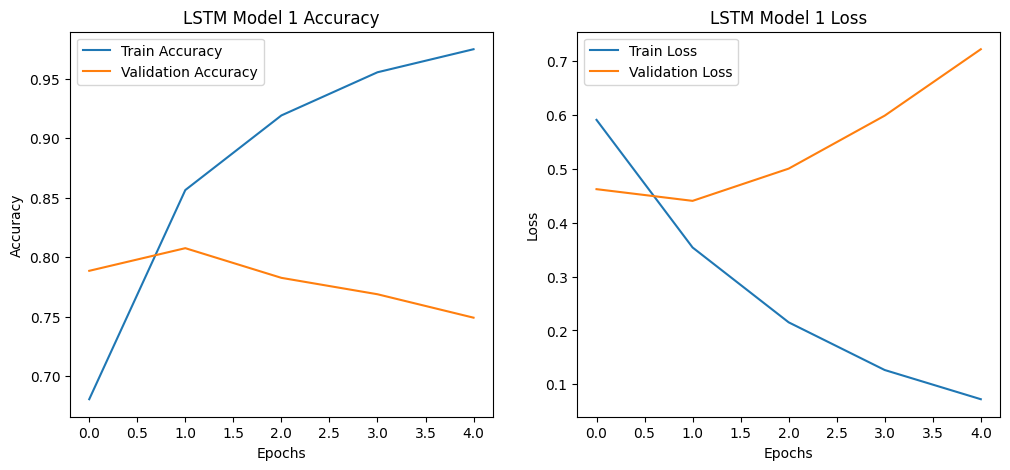

In [15]:
# LSTM Model 1 Evaluation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history_1.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history_1.history['loss'], label='Train Loss')
plt.plot(lstm_history_1.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

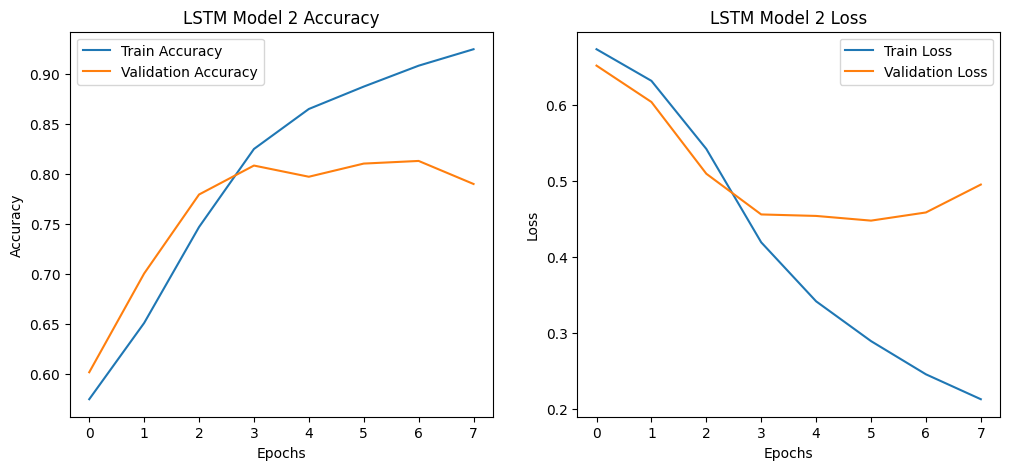

In [16]:
# LSTM Model 2 Evaluation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history_2.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history_2.history['loss'], label='Train Loss')
plt.plot(lstm_history_2.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

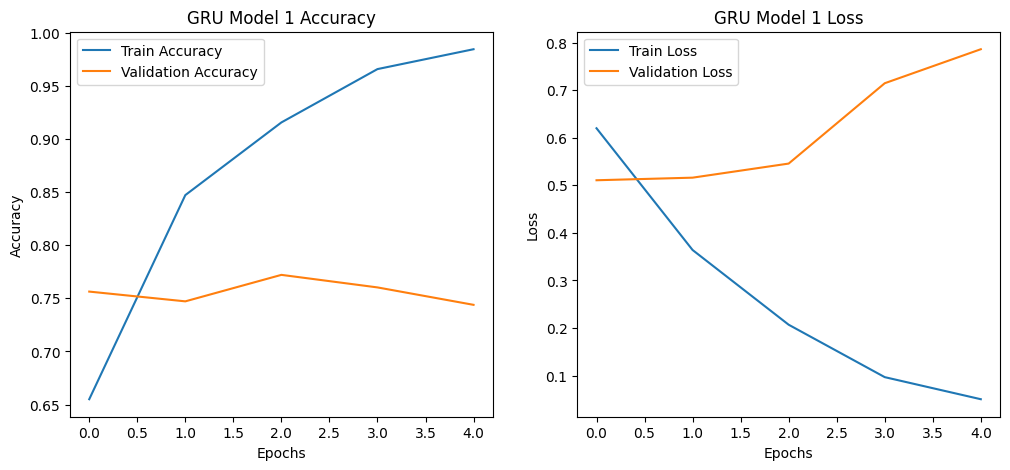

In [17]:
# GRU Model 1 Evaluation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gru_history_1.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history_1.history['loss'], label='Train Loss')
plt.plot(gru_history_1.history['val_loss'], label='Validation Loss')
plt.title('GRU Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

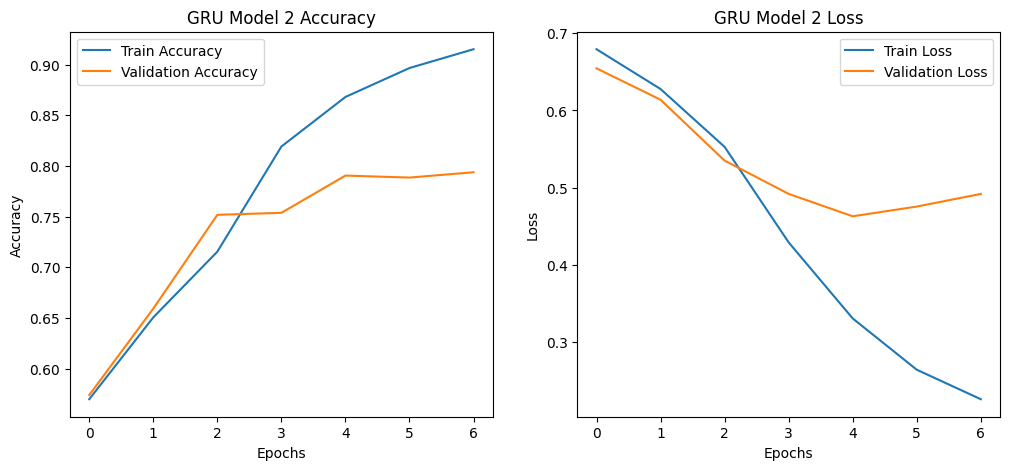

In [18]:
# GRU Model 2 Evaluation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gru_history_2.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history_2.history['loss'], label='Train Loss')
plt.plot(gru_history_2.history['val_loss'], label='Validation Loss')
plt.title('GRU Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
# Evaluating accuracy
# LSTM models
y_val_lstm_1_pred = lstm_model_1.predict(X_val)
y_val_lstm_1_pred = (y_val_lstm_1_pred > 0.5).astype(int)
lstm_accuracy_1 = accuracy_score(y_val, y_val_lstm_1_pred)

y_val_lstm_2_pred = lstm_model_2.predict(X_val)
y_val_lstm_2_pred = (y_val_lstm_2_pred > 0.5).astype(int)
lstm_accuracy_2 = accuracy_score(y_val, y_val_lstm_2_pred)

# GRU models
y_val_gru_1_pred = gru_model_1.predict(X_val)
y_val_gru_1_pred = (y_val_gru_1_pred > 0.5).astype(int)
gru_accuracy_1 = accuracy_score(y_val, y_val_gru_1_pred)

y_val_gru_2_pred = gru_model_2.predict(X_val)
y_val_gru_2_pred = (y_val_gru_2_pred > 0.5).astype(int)
gru_accuracy_2 = accuracy_score(y_val, y_val_gru_2_pred)

# Printing the accuracies
print(f"LSTM model 1 accuracy: {round((lstm_accuracy_1 * 100), 2)}%")
print(f"LSTM model 2 accuracy: {round((lstm_accuracy_2 * 100), 2)}%")
print(f"GRU model 1 accuracy: {round((gru_accuracy_1 * 100), 2)}%")
print(f"GRU model 2 accuracy: {round((gru_accuracy_2 * 100), 2)}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM model 1 accuracy: 74.92%
LSTM model 2 accuracy: 81.02%
GRU model 1 accuracy: 74.39%
GRU model 2 accuracy: 79.05%


Evaluating the accuracy and loss of the models, we notice that in both the initial LSTM and initial GRU models, there was substantial overfitting. The accuracy and loss was significantly better in training than in validation. Also, in both cases the validation loss only increased after the first epoch. After tuning the hyperparameters and introducing early stopping, the overfitting seems to have been reduced, and the validation accuracy and loss are much better in both models.

### Confusion Matrices

Next, we will evaluate the confusion matrices of the models on the validation dataset to better understand how the models are performing.

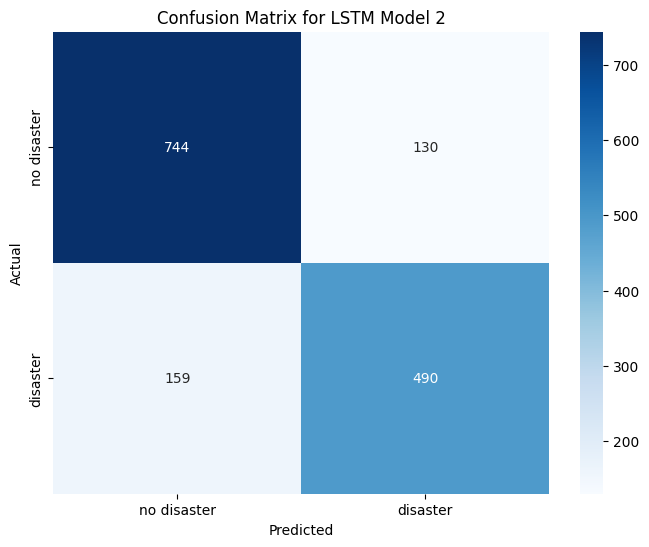

In [20]:
# Confusion matrix for LSTM model 2 
cm_lstm_2 = confusion_matrix(y_val, y_val_lstm_2_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm_2, annot=True, fmt='d', xticklabels=['no disaster', 'disaster'], yticklabels=['no disaster', 'disaster'], cmap='Blues')
plt.title('Confusion Matrix for LSTM Model 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

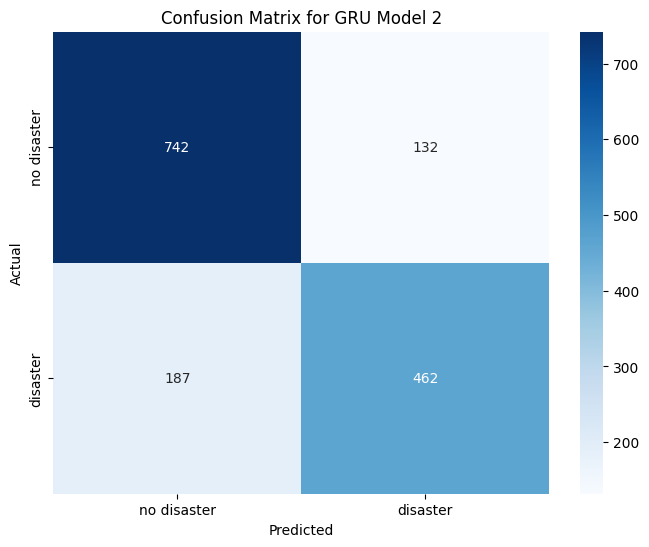

In [21]:
# Confusion matrix for GRU model 2
cm_gru_2 = confusion_matrix(y_val, y_val_gru_2_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru_2, annot=True, fmt='d', xticklabels=['no disaster', 'disaster'], yticklabels=['no disaster', 'disaster'], cmap='Blues')
plt.title('Confusion Matrix for GRU Model 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrices show that both the LSTM and GRU models perform fairly well in predicting the target variable. However, they both tend to predict more false positives than false negatives.

### Test Predictions

Finally, we will make predictions on the test dataset using the LSTM and GRU models and submit the predictions to Kaggle to evaluate the performance of the models on unseen data.

In [22]:
# LSTM model 2 predictions
y_test_lstm_2_pred = lstm_model_2.predict(X_test)
y_test_lstm_2_pred = (y_test_lstm_2_pred > 0.5).astype(int)
test_df['lstm_prediction'] = y_test_lstm_2_pred
lstm_prediction_df = test_df[['id', 'lstm_prediction']]
lstm_prediction_df.columns = ['id', 'target']
lstm_prediction_df.to_csv('output/submission_lstm.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [23]:
# GRU model 2 predictions
y_test_gru_2_pred = gru_model_2.predict(X_test)
y_test_gru_2_pred = (y_test_gru_2_pred > 0.5).astype(int)
test_df['gru_prediction'] = y_test_gru_2_pred
gru_prediction_df = test_df[['id', 'gru_prediction']]
gru_prediction_df.columns = ['id', 'target']
gru_prediction_df.to_csv('output/submission_gru.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


The LSTM model achieved a score of 0.79160 on Kaggle, while the GRU model achieved a score of 0.79282. The GRU model performed slightly better than the LSTM model on the test dataset.

## Conclusion

The LSTM and GRU models both performed well in predicting whether a tweet is about a real disaster or not. They each achieved an accuracy of accuracy of around 80% on the validation and test datasets. The LSTM model may have slightly better accuracy and loss than the GRU model, but the GRU model is simpler and faster to train. It's cool to see the theory behind these models play out in practice!

In the future, we could further tune the hyperparameters of the models, try different preprocessing techniques, and experiment with different architectures to improve the performance of the models. We could also try other deep learning models, such as a bidirectional LSTM or GRU or a transformer model to see if they can achieve better performance.